In [1]:
import IPython.display as display
from src.aki import AKI
from transformers import AutoTokenizer, AutoConfig
from torchvision.transforms import Compose, Resize, Lambda, ToTensor, Normalize
from PIL import Image
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

# replace GenerationMixin to modify attention mask handling
from transformers.generation.utils import GenerationMixin
from src.aki_generation import _aki_update_model_kwargs_for_generation
GenerationMixin._update_model_kwargs_for_generation = _aki_update_model_kwargs_for_generation

In [2]:
def apply_prompt_template(query: str) -> str:
    SYSTEM_BASE = "A chat between a curious user and an artificial intelligence assistant."
    SYSTEM_DETAIL = "The assistant gives helpful, detailed, and polite answers to the user's questions."
    SYSTEM_MESSAGE = SYSTEM_BASE + " " + SYSTEM_DETAIL
    SYSTEM_MESSAGE_ROLE = '<|system|>' + '\n' + SYSTEM_MESSAGE + '<|end|>\n'

    s = (
        f'<s> {SYSTEM_MESSAGE_ROLE}'
        f'<|user|>\n<image>\n{query}<|end|>\n<|assistant|>\n'
    )
    return s


def load_model_and_processor(ckpt_path, config):
    n_px = getattr(config, "n_px", 384)
    norm_mean = getattr(config, "norm_mean", 0.5)
    norm_std = getattr(config, "norm_std", 0.5)
    
    tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
    model = AKI.from_pretrained(ckpt_path, tokenizer=tokenizer)
    image_processor = Compose([
        Resize((n_px, n_px), interpolation=InterpolationMode.BICUBIC, antialias=True),
        Lambda(lambda x: x.convert('RGB')),
        ToTensor(),
        Normalize(mean=(norm_mean, norm_mean, norm_mean), std=(norm_std, norm_std, norm_std))
    ])

    model.eval().cuda()
    print("Model initialization is done.")
    return model, image_processor, tokenizer

In [ ]:
model_path = "aki-phi3.5-mini-4b"
config = AutoConfig.from_pretrained(model_path)
# Load model, image_processor, tokenizer
model, image_processor, tokenizer = load_model_and_processor(model_path, config=config)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights from local directory
Model initialization is done.


In [8]:
def process_input(image_path: str, text_input: str) -> str:
    """
    Processes the input image and text prompt to generate a response from the AKI model.
    
    Args:
    image_path (str): The path of the image.
    text_input (str): The text prompt to accompany the image.
    
    Returns:
    str: The generated text from the model.
    """

    image = Image.open(image_path).convert('RGB')

    display.display(image.resize((int(image.width*0.1), int(image.height*0.1))))
    
    # tokenize text input with the chat template
    prompt = apply_prompt_template(text_input)
    lang_x = tokenizer([prompt], return_tensors='pt', add_special_tokens=False)

    print("Prompt:", prompt)
    
    # Preprocess inputs for the model
    vision_x = image_processor(image)[None, None, None, ...].cuda()

    generation_kwargs = {
        'max_new_tokens': 256,
        'do_sample': False,
    }
    
    # Generate the model's output based on the inputs
    output = model.generate(
        vision_x=vision_x.cuda(),
        lang_x=lang_x['input_ids'].cuda(),
        attention_mask=lang_x['attention_mask'].cuda(),
        **generation_kwargs
    )
    
    # Decode the generated output into readable text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return generated_text

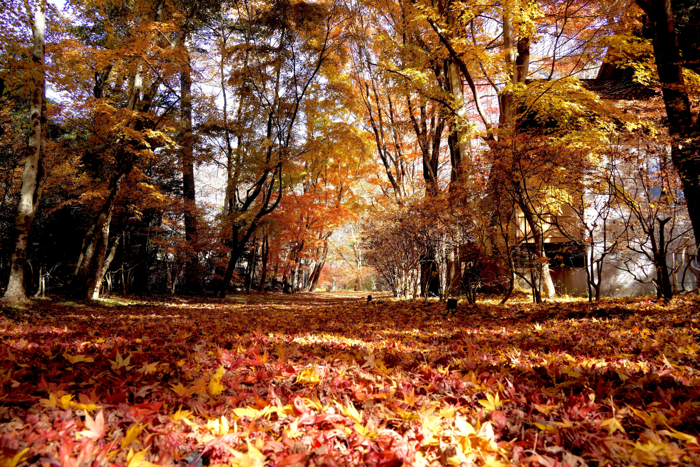

Prompt: <s> <|system|>
A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.<|end|>
<|user|>
<image>
Describe the scene of this image.<|end|>
<|assistant|>

Response:
 The image captures a beautiful autumn day in a park, with a pathway covered in a vibrant carpet of fallen leaves. The leaves are in various shades of red, orange, yellow, and brown, creating a warm and colorful atmosphere. The path is lined with trees displaying beautiful autumn foliage, adding to the picturesque setting.

A few benches are scattered along the path, providing visitors with a place to sit and enjoy the view of the falling leaves and the surrounding trees. The overall scene is serene and inviting, making it an ideal spot for relaxation and appreciating the beauty of the season.


In [9]:
image_path = "example_image/aki_compressed.jpg"
text_input = "Describe the scene of this image."
response = process_input(image_path, text_input)
print("Response:\n", response)